# Banana Collector - REPORT

---

### 1. Load the necessary packages

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment! The next cell code should point to the path to the executbale environment created in Unity, examples for al platforms:

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`


In [2]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments to be used used through Python contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Instantiate a DQN Agent

The next cell code instantiates the Agent class defined in the script **`dqn_agent.py`**.

The Agent is reponsible of:
    - Simulating the environment's long-term rewards through Neural Netowrks forward passes
    - Accumulating experiences in a ReplayBuffer to train the networks on past situations of the environment
    - Perform backpropagation on the model weights to learn from tha ccumulated gradients
    - Update both network's weights every *UPDATE_EVERY* steps to ensure learning

In [5]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

### 4. Define the Deep Q-Learnind algorithm to learn a policy on the environment

The deep Q Learning algorithm pseudo-code:

![alt text](https://cdn-images-1.medium.com/max/998/1*Du1AnMnIEq85EJYh6GmFCA.png)

The algorithm performs 2 forward passes to simulate the long term reward of the taken action, using the formula: 

![alt_text](https://keon.io/images/deep-q-learning/deep-q-learning.png)

We sum the rewards for each episode to measure learning. The environment is said to be solved when the average episodic reward through 100 consecutive episodes is >= 13.0


In [6]:
def dqn(n_episodes=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    # Initialize epsilon & the arrays to accumulate scores & # of dones
    scores = []
    dones = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    # For each episode run the full algorithm
    for i_episode in range(1, n_episodes+1):
        # restart the environment to obtain s0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        # initialize episodic reward
        score = 0
        # until the episode is over:
        while True:
            # select epsilon-greedy action
            action = agent.act(state, eps)
            # simulate environment reaction to the epsilon-greedy action: next state, reward & done
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            # execute algorithm step
            agent.step(state, action, reward, next_state, done)
            # setup next iteration situation
            state = next_state
            # accumulate episodic reward
            score += reward
            # if game over: accumulate done for future check & break while loop
            if done:
                dones.append(1)
                break 
        # accumulate episodic score
        scores_window.append(score)
        scores.append(score)
        # decay epsilon to slowly transition from exploration to exploitation
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if environment is solved, save weights & break the for loop
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'final_model_weights.pth')
            break
    # print # of deaths, should match with # of episodes executed
    print(np.sum(dones))
    return scores
# Run function
scores = dqn()

Episode 100	Average Score: 1.30
Episode 200	Average Score: 5.45
Episode 300	Average Score: 8.24
Episode 400	Average Score: 11.17
Episode 500	Average Score: 12.32
Episode 531	Average Score: 13.00
Environment solved in 431 episodes!	Average Score: 13.00
531


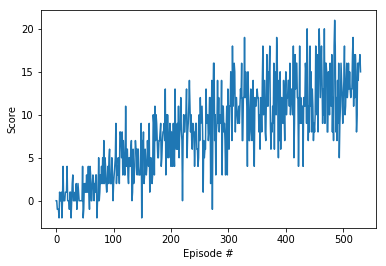

In [10]:
# plot the scores x episode
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [8]:
env.close()

### 5. Future work

Future improvements of the Agent could include:
- single source of parameters in a JSON file
- double DQN
- dueling DQN
- prioritized experience replay
- using raw pixels as input instead of state vector